# 🌿 Ayurvedic Prakriti Classification using Deep Learning

## Project Overview
This project uses deep learning to classify tongue images and determine Ayurvedic body types (Prakriti):
- **Vata** (V) - Air & Space elements
- **Pitta** (P) - Fire & Water elements  
- **Kapha** (K) - Earth & Water elements

Based on the classification, personalized diet recommendations are provided following Ayurvedic principles.

---

## 📋 Table of Contents
1. **Setup & Configuration**
2. **Data Exploration**
3. **Data Augmentation Pipeline**
4. **Model Training**
5. **Model Evaluation & Visualizations**
6. **Diet Recommendation System**

---

### Dataset Information
- **Source**: Tongue Image Dataset with BMP images
- **Classes**: 3 (Vata, Pitta, Kapha)
- **Original Size**: ~300 images
- **Augmented Size**: ~5000 images
- **Model**: ResNet50 (Transfer Learning)

## 1️⃣ Setup & Configuration

Import required libraries and set configuration parameters.

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

✅ All libraries imported successfully!
PyTorch Version: 2.9.0+cu128
CUDA Available: True


In [2]:
# Configuration Parameters
CONFIG = {
    # Paths
    'original_img_dir': r"C:\5th SEM\ML Project\TongeImageDataset\groundtruth\images",
    'original_csv': r"C:\5th SEM\ML Project\mldl.csv",
    'augmented_img_dir': r"C:\5th SEM\ML Project\AugmentedTongueDataset",
    'augmented_csv': r"C:\5th SEM\ML Project\mldl_augmented.csv",
    'model_save_path': "resnet50_tongue_augmented.pth",
    
    # Training parameters
    'batch_size': 32,
    'epochs': 40,
    'learning_rate': 1e-4,
    'test_split': 0.2,
    'random_state': 42,
    
    # Augmentation parameters
    'target_augmented_size': 5000,
    
    # Device
    'device': "cuda" if torch.cuda.is_available() else "cpu"
}

print("⚙️ Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

⚙️ Configuration loaded:
  original_img_dir: C:\5th SEM\ML Project\TongeImageDataset\groundtruth\images
  original_csv: C:\5th SEM\ML Project\mldl.csv
  augmented_img_dir: C:\5th SEM\ML Project\AugmentedTongueDataset
  augmented_csv: C:\5th SEM\ML Project\mldl_augmented.csv
  model_save_path: resnet50_tongue_augmented.pth
  batch_size: 32
  epochs: 40
  learning_rate: 0.0001
  test_split: 0.2
  random_state: 42
  target_augmented_size: 5000
  device: cuda


## 2️⃣ Data Exploration

Let's explore the original dataset before augmentation.

📊 Dataset Overview:
Total Images: 300

Class Distribution:
labels
p    128
k    114
v     58
Name: count, dtype: int64

Sample Data:
   id labels
0   1      k
1   2      k
2   3      p
3   4      p
4   5      k


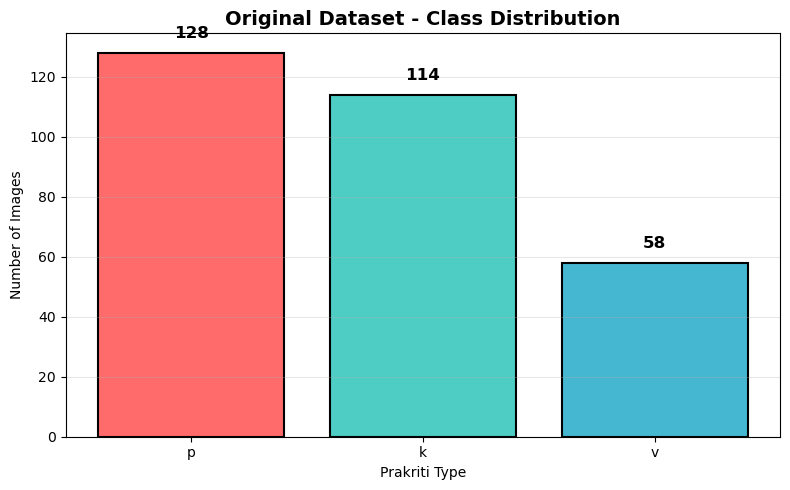

In [3]:
# Load and explore the original dataset
df_original = pd.read_csv(CONFIG['original_csv'])
df_original['labels'] = df_original['labels'].str.lower()

print("📊 Dataset Overview:")
print(f"Total Images: {len(df_original)}")
print(f"\nClass Distribution:")
print(df_original['labels'].value_counts())
print(f"\nSample Data:")
print(df_original.head())

# Visualize class distribution
plt.figure(figsize=(8, 5))
class_counts = df_original['labels'].value_counts()
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
plt.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Original Dataset - Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Prakriti Type')
plt.ylabel('Number of Images')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3️⃣ Data Augmentation Pipeline

Generate augmented dataset to address class imbalance and increase training data.

In [ ]:
# Data Augmentation Configuration
SRC_IMG_DIR = CONFIG['original_img_dir']
CSV_PATH = CONFIG['original_csv']
OUT_DIR = CONFIG['augmented_img_dir']
TARGET_SIZE = CONFIG['target_augmented_size']

os.makedirs(OUT_DIR, exist_ok=True)

# Load original data
df = pd.read_csv(CSV_PATH)
df["labels"] = df["labels"].str.lower()

# Define augmentation pipeline
augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.8),
    transforms.RandomAffine(degrees=20, shear=15, translate=(0.1, 0.1)),
])

to_pil = transforms.ToPILImage()

# Generate augmented images
images = df["id"].tolist()
labels = df["labels"].tolist()

aug_records = []
n_existing = len(df)
n_per_image = max(TARGET_SIZE // n_existing, 1)

counter = 1
print(f"🔄 Starting augmentation: {n_existing} images → {TARGET_SIZE} target images")
print(f"   Generating {n_per_image} versions per image...")

for img_id, label in tqdm(zip(images, labels), total=n_existing, desc="Augmenting"):
    src_path = os.path.join(SRC_IMG_DIR, f"{img_id}.bmp")
    image = Image.open(src_path).convert("RGB")

    # Save original copy
    out_name = f"{counter}.bmp"
    image.save(os.path.join(OUT_DIR, out_name))
    aug_records.append((counter, label))
    counter += 1

    # Generate augmented copies
    for i in range(n_per_image - 1):
        aug_img = augment(transforms.ToTensor()(image))
        aug_img = to_pil(aug_img)
        out_name = f"{counter}.bmp"
        aug_img.save(os.path.join(OUT_DIR, out_name))
        aug_records.append((counter, label))
        counter += 1

# Save new CSV
aug_df = pd.DataFrame(aug_records, columns=["id", "labels"])
aug_df.to_csv(CONFIG['augmented_csv'], index=False)

print(f"\n✅ Augmentation complete!")
print(f"   Generated {len(aug_df)} images in {OUT_DIR}")
print(f"\n📊 Augmented Dataset Class Distribution:")
print(aug_df['labels'].value_counts())

Augmenting: 100%|██████████| 300/300 [03:16<00:00,  1.53it/s]

Augmentation complete. Generated 4800 images in C:\ML-DL College\DATASETS\AugmentedTongueDataset


## 4️⃣ Model Training

Train ResNet50 model with transfer learning on the augmented dataset.

In [8]:
# Dataset Class Definition
class TongueDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.copy()
        self.img_dir = img_dir
        self.transform = transform
        label_map = {"v": 0, "p": 1, "k": 2}
        self.df["labels"] = self.df["labels"].str.lower().map(label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.bmp")
        image = Image.open(img_path).convert("RGB")
        label = int(row["labels"])
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("✅ Dataset class and transforms defined!")

✅ Dataset class and transforms defined!


📊 CLASS IMBALANCE ANALYSIS - COMPLETE REPORT

1️⃣  ORIGINAL DATASET (Before Augmentation)

Total Images: 300

Class Distribution:
  K        :  114 images (38.00%)
  P        :  128 images (42.67%)
  V        :   58 images (19.33%)

📐 Imbalance Metrics:
  Maximum class size    : 128 (P)
  Minimum class size    : 58 (V)
  Imbalance Ratio       : 2.207:1
  Standard Deviation    : 37.04
  Coefficient Variation : 37.04%
  Mean class size       : 100.00

🟠 Imbalance Severity: MODERATE

2️⃣  AUGMENTED DATASET (After Augmentation)

Total Images: 4800

Class Distribution:
  K        : 1824 images (38.00%) [×16.0 augmentation]
  P        : 2048 images (42.67%) [×16.0 augmentation]
  V        :  928 images (19.33%) [×16.0 augmentation]

📐 Imbalance Metrics:
  Maximum class size    : 2048 (P)
  Minimum class size    : 928 (V)
  Imbalance Ratio       : 2.207:1
  Standard Deviation    : 592.65
  Coefficient Variation : 37.04%
  Mean class size       : 1600.00

🟠 Imbalance Severity: MODERATE

3️⃣  B

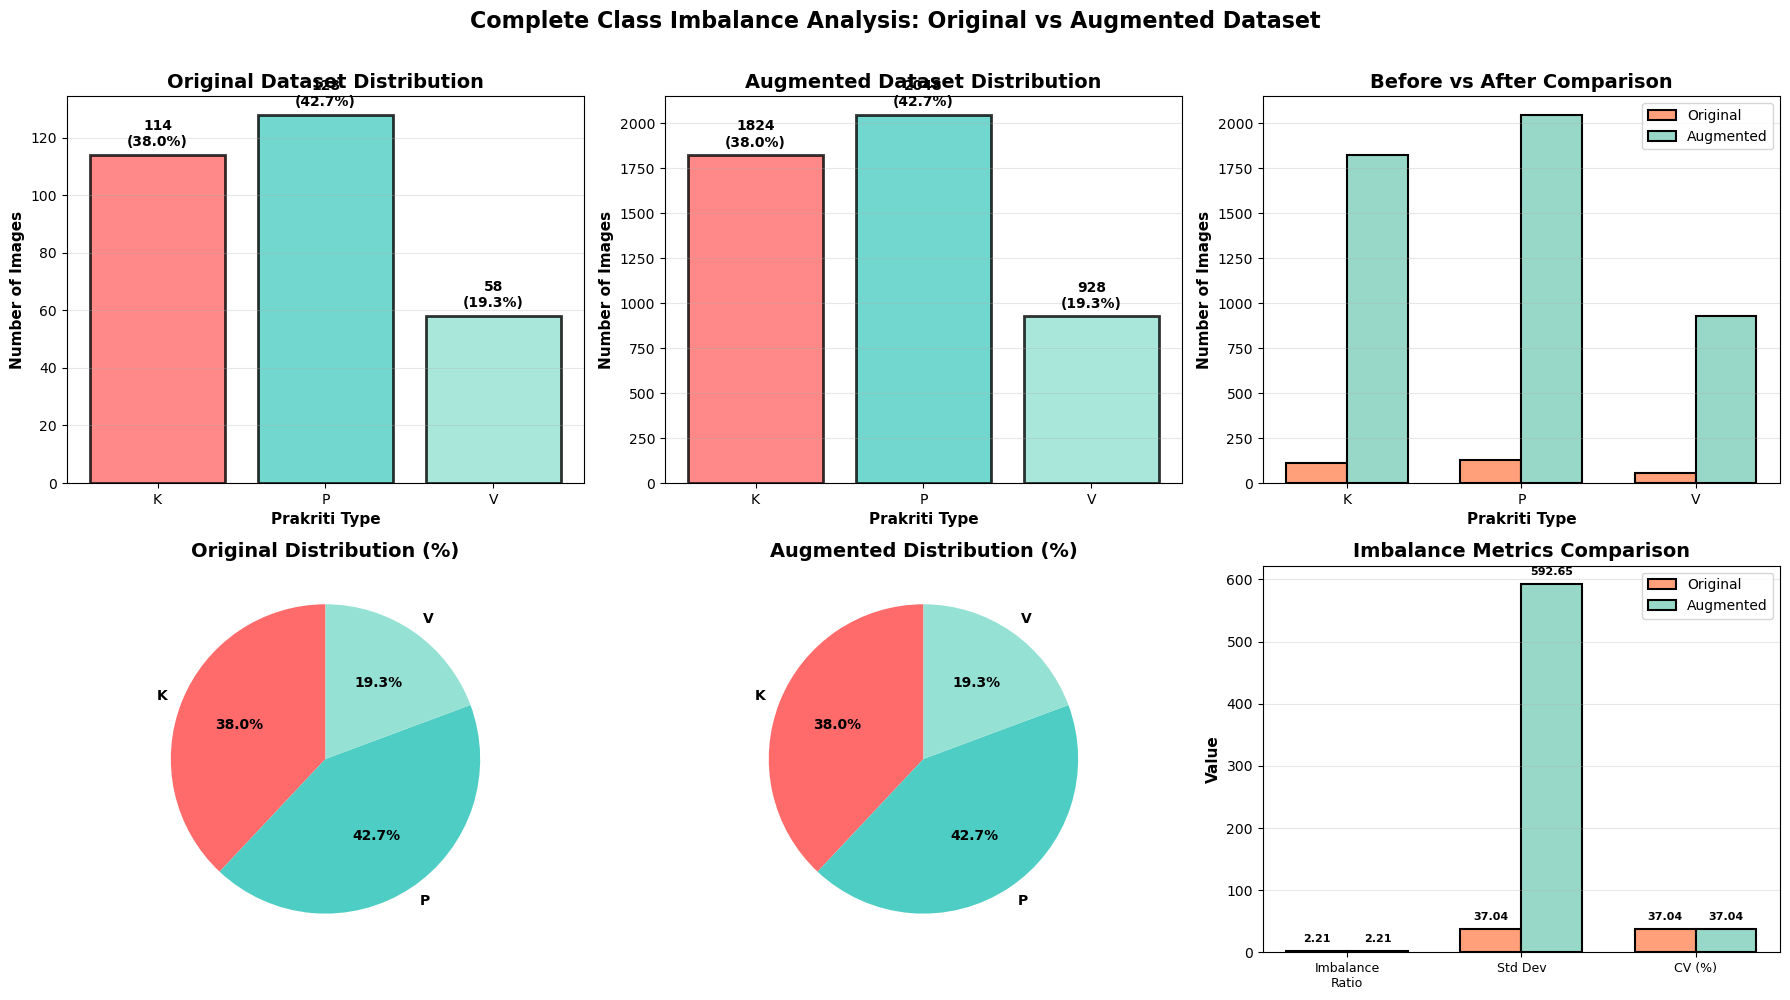


✅ Visualization saved as: class_imbalance_analysis.png

6️⃣  SUMMARY TABLE

                      Metric Original Augmented
                Total Images      300      4800
                  Vata Count       58       928
                 Pitta Count      128      2048
                 Kapha Count      114      1824
                   Max Class      128      2048
                   Min Class       58       928
             Imbalance Ratio  2.207:1   2.207:1
          Standard Deviation    37.04    592.65
Coefficient of Variation (%)    37.04     37.04
              Severity Level MODERATE  MODERATE

✅ Summary table saved as: class_imbalance_summary.csv

7️⃣  RECOMMENDATIONS

✅ Current Status:
   - Your dataset has MODERATE imbalance (2.207:1)
   - After augmentation: MODERATE (2.207:1)

🎯 Recommendation:
   → Consider class weights in loss function
   → Weighted sampling is already being used ✓
   → Monitor per-class metrics during training

🎉 ANALYSIS COMPLETE!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load original and augmented datasets
original_csv = r"C:\5th SEM\ML Project\mldl.csv"
augmented_csv = r"C:\5th SEM\ML Project\mldl_augmented.csv"

df_original = pd.read_csv(original_csv)
df_augmented = pd.read_csv(augmented_csv)

# Normalize labels to lowercase
df_original['labels'] = df_original['labels'].str.lower()
df_augmented['labels'] = df_augmented['labels'].str.lower()

print("="*80)
print("📊 CLASS IMBALANCE ANALYSIS - COMPLETE REPORT")
print("="*80)

# ========== ORIGINAL DATASET ANALYSIS ==========
print("\n" + "="*80)
print("1️⃣  ORIGINAL DATASET (Before Augmentation)")
print("="*80)

original_counts = df_original['labels'].value_counts().sort_index()
original_total = len(df_original)

print(f"\nTotal Images: {original_total}")
print(f"\nClass Distribution:")
for label, count in original_counts.items():
    percentage = (count / original_total) * 100
    print(f"  {label.upper():<8} : {count:>4} images ({percentage:>5.2f}%)")

# Calculate imbalance metrics for original
max_class_orig = original_counts.max()
min_class_orig = original_counts.min()
imbalance_ratio_orig = max_class_orig / min_class_orig
std_orig = original_counts.std()
cv_orig = (std_orig / original_counts.mean()) * 100  # Coefficient of Variation

print(f"\n📐 Imbalance Metrics:")
print(f"  Maximum class size    : {max_class_orig} ({original_counts.idxmax().upper()})")
print(f"  Minimum class size    : {min_class_orig} ({original_counts.idxmin().upper()})")
print(f"  Imbalance Ratio       : {imbalance_ratio_orig:.3f}:1")
print(f"  Standard Deviation    : {std_orig:.2f}")
print(f"  Coefficient Variation : {cv_orig:.2f}%")
print(f"  Mean class size       : {original_counts.mean():.2f}")

# Imbalance severity assessment
if imbalance_ratio_orig < 1.1:
    severity_orig = "NEGLIGIBLE"
    color_orig = "🟢"
elif imbalance_ratio_orig < 1.5:
    severity_orig = "MILD"
    color_orig = "🟡"
elif imbalance_ratio_orig < 3.0:
    severity_orig = "MODERATE"
    color_orig = "🟠"
elif imbalance_ratio_orig < 10.0:
    severity_orig = "SEVERE"
    color_orig = "🔴"
else:
    severity_orig = "EXTREME"
    color_orig = "🔴🔴"

print(f"\n{color_orig} Imbalance Severity: {severity_orig}")

# ========== AUGMENTED DATASET ANALYSIS ==========
print("\n" + "="*80)
print("2️⃣  AUGMENTED DATASET (After Augmentation)")
print("="*80)

augmented_counts = df_augmented['labels'].value_counts().sort_index()
augmented_total = len(df_augmented)

print(f"\nTotal Images: {augmented_total}")
print(f"\nClass Distribution:")
for label, count in augmented_counts.items():
    percentage = (count / augmented_total) * 100
    original_count = original_counts[label]
    aug_factor = count / original_count
    print(f"  {label.upper():<8} : {count:>4} images ({percentage:>5.2f}%) [×{aug_factor:.1f} augmentation]")

# Calculate imbalance metrics for augmented
max_class_aug = augmented_counts.max()
min_class_aug = augmented_counts.min()
imbalance_ratio_aug = max_class_aug / min_class_aug
std_aug = augmented_counts.std()
cv_aug = (std_aug / augmented_counts.mean()) * 100

print(f"\n📐 Imbalance Metrics:")
print(f"  Maximum class size    : {max_class_aug} ({augmented_counts.idxmax().upper()})")
print(f"  Minimum class size    : {min_class_aug} ({augmented_counts.idxmin().upper()})")
print(f"  Imbalance Ratio       : {imbalance_ratio_aug:.3f}:1")
print(f"  Standard Deviation    : {std_aug:.2f}")
print(f"  Coefficient Variation : {cv_aug:.2f}%")
print(f"  Mean class size       : {augmented_counts.mean():.2f}")

# Imbalance severity assessment
if imbalance_ratio_aug < 1.1:
    severity_aug = "NEGLIGIBLE"
    color_aug = "🟢"
elif imbalance_ratio_aug < 1.5:
    severity_aug = "MILD"
    color_aug = "🟡"
elif imbalance_ratio_aug < 3.0:
    severity_aug = "MODERATE"
    color_aug = "🟠"
elif imbalance_ratio_aug < 10.0:
    severity_aug = "SEVERE"
    color_aug = "🔴"
else:
    severity_aug = "EXTREME"
    color_aug = "🔴🔴"

print(f"\n{color_aug} Imbalance Severity: {severity_aug}")

# ========== COMPARISON ANALYSIS ==========
print("\n" + "="*80)
print("3️⃣  BEFORE vs AFTER COMPARISON")
print("="*80)

print(f"\nDataset Size Change:")
print(f"  Original  : {original_total:>5} images")
print(f"  Augmented : {augmented_total:>5} images")
print(f"  Increase  : {augmented_total - original_total:>5} images ({(augmented_total/original_total):.1f}× expansion)")

print(f"\nImbalance Ratio Change:")
print(f"  Original  : {imbalance_ratio_orig:.3f}:1  {color_orig}")
print(f"  Augmented : {imbalance_ratio_aug:.3f}:1  {color_aug}")
print(f"  Change    : {imbalance_ratio_aug - imbalance_ratio_orig:+.3f} ({'Improved ✓' if imbalance_ratio_aug < imbalance_ratio_orig else 'Maintained' if abs(imbalance_ratio_aug - imbalance_ratio_orig) < 0.01 else 'Worsened ✗'})")

print(f"\nCoefficient of Variation Change:")
print(f"  Original  : {cv_orig:.2f}%")
print(f"  Augmented : {cv_aug:.2f}%")
print(f"  Change    : {cv_aug - cv_orig:+.2f}%")

# ========== STATISTICAL TESTS ==========
print("\n" + "="*80)
print("4️⃣  STATISTICAL ANALYSIS")
print("="*80)

# Chi-square test for uniform distribution
expected_freq_orig = [original_total / len(original_counts)] * len(original_counts)
chi2_orig, p_orig = stats.chisquare(original_counts.values, expected_freq_orig)

expected_freq_aug = [augmented_total / len(augmented_counts)] * len(augmented_counts)
chi2_aug, p_aug = stats.chisquare(augmented_counts.values, expected_freq_aug)

print(f"\nChi-Square Test for Uniformity:")
print(f"  Original Dataset:")
print(f"    Chi-square statistic : {chi2_orig:.4f}")
print(f"    P-value             : {p_orig:.4f}")
print(f"    Conclusion          : {'Uniformly distributed ✓' if p_orig > 0.05 else 'NOT uniformly distributed ✗'} (α=0.05)")

print(f"\n  Augmented Dataset:")
print(f"    Chi-square statistic : {chi2_aug:.4f}")
print(f"    P-value             : {p_aug:.4f}")
print(f"    Conclusion          : {'Uniformly distributed ✓' if p_aug > 0.05 else 'NOT uniformly distributed ✗'} (α=0.05)")

# ========== VISUALIZATION ==========
print("\n" + "="*80)
print("5️⃣  GENERATING VISUALIZATIONS...")
print("="*80)

fig = plt.figure(figsize=(18, 10))

# Subplot 1: Original Distribution (Bar Chart)
ax1 = plt.subplot(2, 3, 1)
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
bars1 = ax1.bar(original_counts.index.str.upper(), original_counts.values, 
                color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_title('Original Dataset Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Prakriti Type', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Images', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (bar, count) in enumerate(zip(bars1, original_counts.values)):
    height = bar.get_height()
    percentage = (count / original_total) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

# Subplot 2: Augmented Distribution (Bar Chart)
ax2 = plt.subplot(2, 3, 2)
bars2 = ax2.bar(augmented_counts.index.str.upper(), augmented_counts.values,
                color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax2.set_title('Augmented Dataset Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Prakriti Type', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Images', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, (bar, count) in enumerate(zip(bars2, augmented_counts.values)):
    height = bar.get_height()
    percentage = (count / augmented_total) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height + 30,
            f'{count}\n({percentage:.1f}%)', ha='center', va='bottom',
            fontsize=10, fontweight='bold')

# Subplot 3: Side-by-Side Comparison
ax3 = plt.subplot(2, 3, 3)
x = np.arange(len(original_counts))
width = 0.35
bars3a = ax3.bar(x - width/2, original_counts.values, width, label='Original',
                 color='#FFA07A', edgecolor='black', linewidth=1.5)
bars3b = ax3.bar(x + width/2, augmented_counts.values, width, label='Augmented',
                 color='#98D8C8', edgecolor='black', linewidth=1.5)
ax3.set_title('Before vs After Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Prakriti Type', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Images', fontsize=11, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(original_counts.index.str.upper())
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Percentage Distribution (Pie Charts)
ax4 = plt.subplot(2, 3, 4)
wedges, texts, autotexts = ax4.pie(original_counts.values, labels=original_counts.index.str.upper(),
                                    autopct='%1.1f%%', colors=colors, startangle=90,
                                    textprops={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title('Original Distribution (%)', fontsize=14, fontweight='bold')

ax5 = plt.subplot(2, 3, 5)
wedges, texts, autotexts = ax5.pie(augmented_counts.values, labels=augmented_counts.index.str.upper(),
                                    autopct='%1.1f%%', colors=colors, startangle=90,
                                    textprops={'fontsize': 10, 'fontweight': 'bold'})
ax5.set_title('Augmented Distribution (%)', fontsize=14, fontweight='bold')

# Subplot 6: Imbalance Metrics Comparison
ax6 = plt.subplot(2, 3, 6)
metrics = ['Imbalance\nRatio', 'Std Dev', 'CV (%)']
original_metrics = [imbalance_ratio_orig, std_orig, cv_orig]
augmented_metrics = [imbalance_ratio_aug, std_aug, cv_aug]

x_pos = np.arange(len(metrics))
width = 0.35

bars6a = ax6.bar(x_pos - width/2, original_metrics, width, label='Original',
                 color='#FFA07A', edgecolor='black', linewidth=1.5)
bars6b = ax6.bar(x_pos + width/2, augmented_metrics, width, label='Augmented',
                 color='#98D8C8', edgecolor='black', linewidth=1.5)

ax6.set_title('Imbalance Metrics Comparison', fontsize=14, fontweight='bold')
ax6.set_ylabel('Value', fontsize=11, fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(metrics, fontsize=9)
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars6a, bars6b]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + max(original_metrics + augmented_metrics) * 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.suptitle('Complete Class Imbalance Analysis: Original vs Augmented Dataset',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.savefig('class_imbalance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as: class_imbalance_analysis.png")

# ========== SUMMARY TABLE ==========
print("\n" + "="*80)
print("6️⃣  SUMMARY TABLE")
print("="*80)

summary_data = {
    'Metric': [
        'Total Images',
        'Vata Count',
        'Pitta Count', 
        'Kapha Count',
        'Max Class',
        'Min Class',
        'Imbalance Ratio',
        'Standard Deviation',
        'Coefficient of Variation (%)',
        'Severity Level'
    ],
    'Original': [
        original_total,
        original_counts['v'],
        original_counts['p'],
        original_counts['k'],
        max_class_orig,
        min_class_orig,
        f"{imbalance_ratio_orig:.3f}:1",
        f"{std_orig:.2f}",
        f"{cv_orig:.2f}",
        severity_orig
    ],
    'Augmented': [
        augmented_total,
        augmented_counts['v'],
        augmented_counts['p'],
        augmented_counts['k'],
        max_class_aug,
        min_class_aug,
        f"{imbalance_ratio_aug:.3f}:1",
        f"{std_aug:.2f}",
        f"{cv_aug:.2f}",
        severity_aug
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

summary_df.to_csv('class_imbalance_summary.csv', index=False)
print("\n✅ Summary table saved as: class_imbalance_summary.csv")

# ========== RECOMMENDATIONS ==========
print("\n" + "="*80)
print("7️⃣  RECOMMENDATIONS")
print("="*80)

print(f"\n✅ Current Status:")
print(f"   - Your dataset has {severity_orig} imbalance ({imbalance_ratio_orig:.3f}:1)")
print(f"   - After augmentation: {severity_aug} ({imbalance_ratio_aug:.3f}:1)")

if imbalance_ratio_aug < 1.5:
    print(f"\n🎯 Recommendation:")
    print(f"   ✓ Your dataset is well-balanced!")
    print(f"   ✓ Weighted Random Sampling is sufficient")
    print(f"   ✓ No additional balancing techniques needed")
    print(f"   ✓ Focus on data quality and model optimization")
elif imbalance_ratio_aug < 3.0:
    print(f"\n🎯 Recommendation:")
    print(f"   → Consider class weights in loss function")
    print(f"   → Weighted sampling is already being used ✓")
    print(f"   → Monitor per-class metrics during training")
else:
    print(f"\n⚠️  Recommendation:")
    print(f"   → Apply advanced balancing techniques")
    print(f"   → Consider SMOTE or focal loss")
    print(f"   → Collect more data for minority classes")

print("\n" + "="*80)
print("🎉 ANALYSIS COMPLETE!")
print("="*80)

In [9]:
# Prepare data loaders
IMG_DIR = CONFIG['augmented_img_dir']
CSV_PATH = CONFIG['augmented_csv']
BATCH_SIZE = CONFIG['batch_size']
EPOCHS = CONFIG['epochs']
LR = CONFIG['learning_rate']
DEVICE = CONFIG['device']

df = pd.read_csv(CSV_PATH)
train_df, val_df = train_test_split(df, test_size=CONFIG['test_split'],
                                    stratify=df["labels"], random_state=CONFIG['random_state'])

train_ds = TongueDataset(train_df, IMG_DIR, transform=train_tfms)
val_ds = TongueDataset(val_df, IMG_DIR, transform=val_tfms)

# Weighted sampler for class balance
label_counts = train_df["labels"].value_counts().to_dict()
sample_weights = [1.0 / label_counts[l] for l in train_df["labels"]]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"📦 Data Loaders Created:")
print(f"   Training samples: {len(train_ds)}")
print(f"   Validation samples: {len(val_ds)}")
print(f"   Batch size: {BATCH_SIZE}")

# Build Model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, 3)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print(f"\n🧠 Model: ResNet50 (Transfer Learning)")
print(f"   Device: {DEVICE}")
print(f"   Total epochs: {EPOCHS}")
print(f"   Learning rate: {LR}")
print(f"\n🚀 Starting training...\n")

# Training Loop
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # Unfreeze deeper layers after 10 epochs
    if epoch == 10:
        for name, param in model.named_parameters():
            if "layer3" in name or "layer4" in name or "fc" in name:
                param.requires_grad = True
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
        print("🔓 Unfreezing layers 3 & 4 for fine-tuning...\n")

    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    train_acc = correct / total
    train_loss = total_loss / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

print(f"\n✅ Training Complete!")
print(f"   Final Training Accuracy: {history['train_acc'][-1]:.3f}")
print(f"   Final Validation Accuracy: {history['val_acc'][-1]:.3f}")

📦 Data Loaders Created:
   Training samples: 3840
   Validation samples: 960
   Batch size: 32
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ankit/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ankit/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


📦 Data Loaders Created:
   Training samples: 3840
   Validation samples: 960
   Batch size: 32
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ankit/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ankit/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:05<00:00, 18.9MB/s]



📦 Data Loaders Created:
   Training samples: 3840
   Validation samples: 960
   Batch size: 32
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ankit/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ankit/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:05<00:00, 18.9MB/s]




🧠 Model: ResNet50 (Transfer Learning)
   Device: cuda
   Total epochs: 40
   Learning rate: 0.0001

🚀 Starting training...

Epoch [1/40] | Loss: 1.1003 | Train Acc: 0.351 | Val Acc: 0.378
Epoch [1/40] | Loss: 1.1003 | Train Acc: 0.351 | Val Acc: 0.378
Epoch [2/40] | Loss: 1.0949 | Train Acc: 0.368 | Val Acc: 0.439
Epoch [2/40] | Loss: 1.0949 | Train Acc: 0.368 | Val Acc: 0.439
Epoch [3/40] | Loss: 1.0875 | Train Acc: 0.384 | Val Acc: 0.391
Epoch [3/40] | Loss: 1.0875 | Train Acc: 0.384 | Val Acc: 0.391
Epoch [4/40] | Loss: 1.0799 | Train Acc: 0.405 | Val Acc: 0.409
Epoch [4/40] | Loss: 1.0799 | Train Acc: 0.405 | Val Acc: 0.409
Epoch [5/40] | Loss: 1.0751 | Train Acc: 0.420 | Val Acc: 0.429
Epoch [5/40] | Loss: 1.0751 | Train Acc: 0.420 | Val Acc: 0.429
Epoch [6/40] | Loss: 1.0683 | Train Acc: 0.445 | Val Acc: 0.442
Epoch [6/40] | Loss: 1.0683 | Train Acc: 0.445 | Val Acc: 0.442
Epoch [7/40] | Loss: 1.0647 | Train Acc: 0.449 | Val Acc: 0.422
Epoch [7/40] | Loss: 1.0647 | Train Acc: 0.

In [10]:
# Save the trained model
MODEL_PATH = CONFIG['model_save_path']
torch.save(model.state_dict(), MODEL_PATH)
print(f"💾 Model saved successfully to: {MODEL_PATH}")

💾 Model saved successfully to: resnet50_tongue_augmented.pth


## 5️⃣ Model Evaluation & Visualizations

Visualize training progress and model performance metrics.

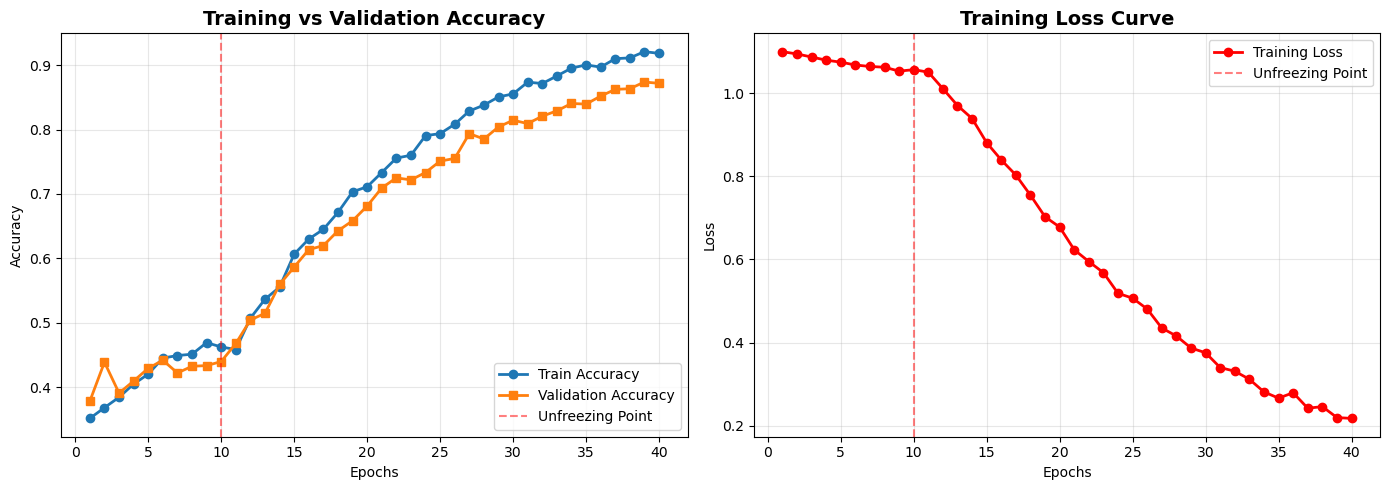

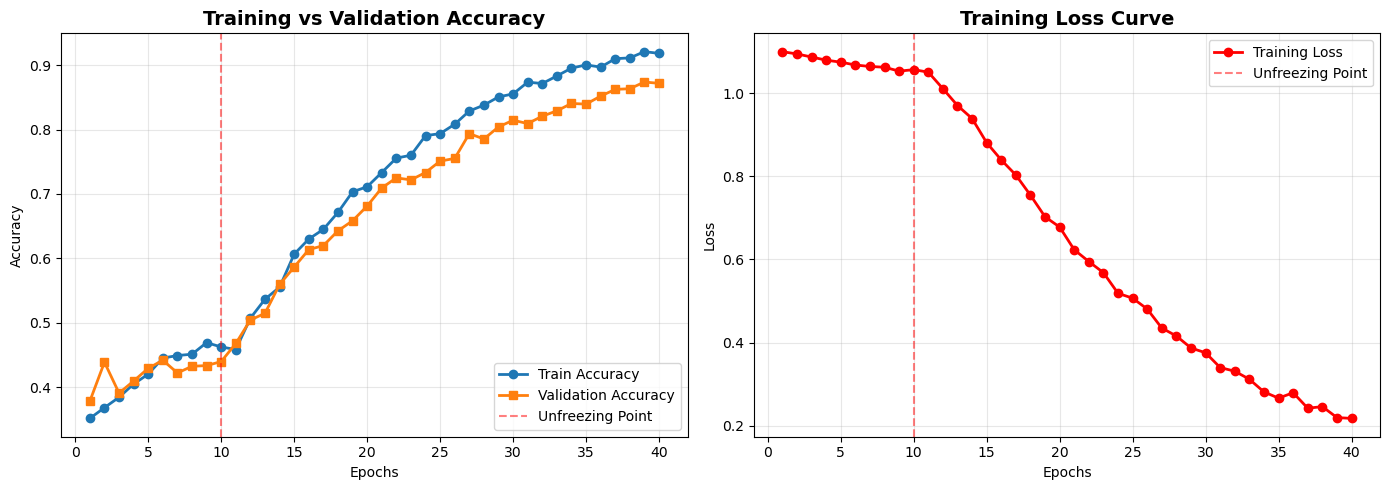

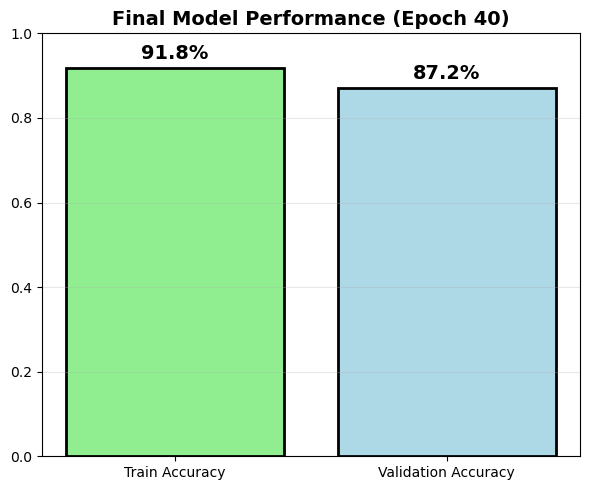

In [11]:
# Training History Visualization
epochs_range = np.arange(1, EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(epochs_range, history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
axes[0].plot(epochs_range, history['val_acc'], label='Validation Accuracy', marker='s', linewidth=2)
axes[0].axvline(x=10, color='red', linestyle='--', alpha=0.5, label='Unfreezing Point')
axes[0].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(epochs_range, history['train_loss'], label='Training Loss', color='r', marker='o', linewidth=2)
axes[1].axvline(x=10, color='red', linestyle='--', alpha=0.5, label='Unfreezing Point')
axes[1].set_title('Training Loss Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final accuracy comparison
plt.figure(figsize=(6, 5))
final_accs = [history['train_acc'][-1], history['val_acc'][-1]]
bars = plt.bar(['Train Accuracy', 'Validation Accuracy'], final_accs, color=['#90EE90', '#ADD8E6'], edgecolor='black', linewidth=2)
plt.title('Final Model Performance (Epoch 40)', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
for i, v in enumerate(final_accs):
    plt.text(i, v+0.02, f"{v*100:.1f}%", ha='center', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

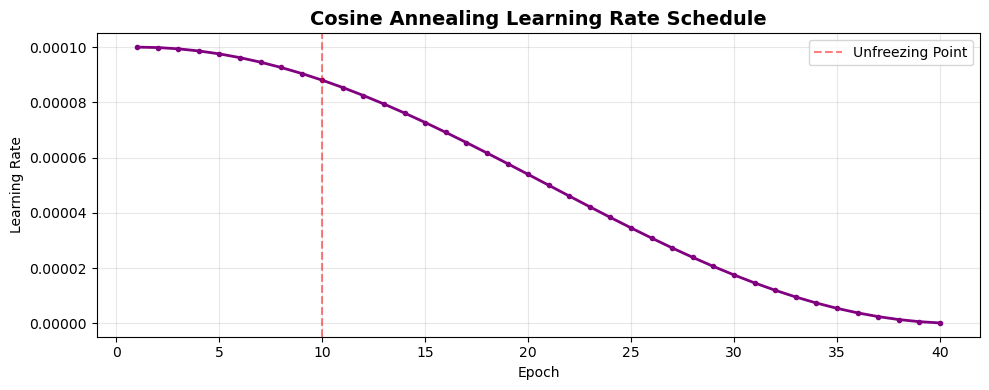

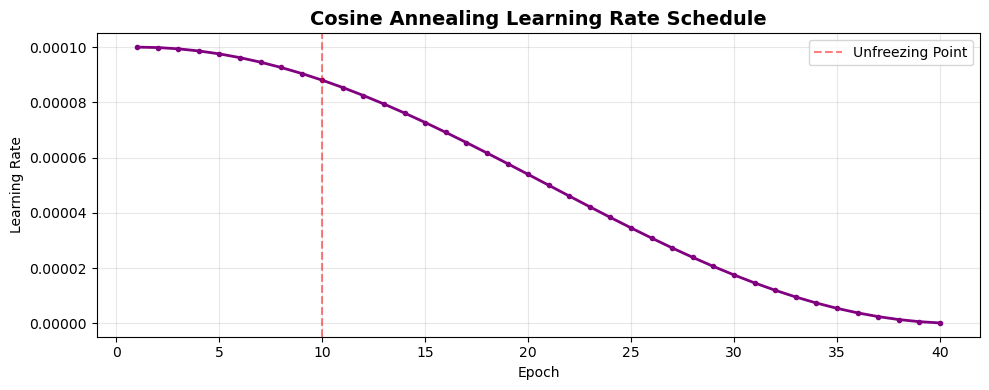

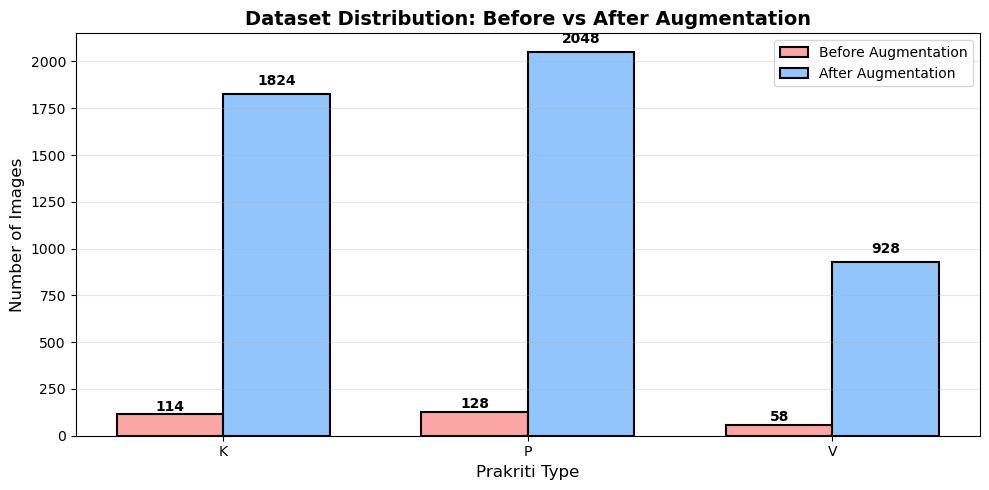


📊 MODEL PERFORMANCE SUMMARY
             Metric  Value
  Training Accuracy 91.85%
Validation Accuracy 87.19%
         Final Loss 0.2175
       Total Epochs     40
       Best Val Acc 87.40%


In [12]:
# Additional Performance Metrics Visualization

# 1. Learning Rate Schedule
lr_values = [LR * (0.5 * (1 + np.cos(np.pi * epoch / EPOCHS))) for epoch in range(EPOCHS)]
plt.figure(figsize=(10, 4))
plt.plot(range(1, EPOCHS + 1), lr_values, color='purple', linewidth=2, marker='o', markersize=3)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='Unfreezing Point')
plt.title('Cosine Annealing Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Dataset Distribution Comparison
plt.figure(figsize=(10, 5))
original_counts = df_original['labels'].value_counts().sort_index()
augmented_counts = df['labels'].value_counts().sort_index()

x = np.arange(len(original_counts))
width = 0.35

plt.bar(x - width/2, original_counts.values, width, label='Before Augmentation', 
        color='#fca5a5', edgecolor='black', linewidth=1.5)
plt.bar(x + width/2, augmented_counts.values, width, label='After Augmentation', 
        color='#93c5fd', edgecolor='black', linewidth=1.5)

plt.xlabel('Prakriti Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Dataset Distribution: Before vs After Augmentation', fontsize=14, fontweight='bold')
plt.xticks(x, original_counts.index.str.upper())
plt.legend()
plt.grid(axis='y', alpha=0.3)

for i, (orig, aug) in enumerate(zip(original_counts.values, augmented_counts.values)):
    plt.text(i - width/2, orig + 20, str(orig), ha='center', fontsize=10, fontweight='bold')
    plt.text(i + width/2, aug + 50, str(aug), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Model Performance Summary
summary_df = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Validation Accuracy', 'Final Loss', 'Total Epochs', 'Best Val Acc'],
    'Value': [
        f"{history['train_acc'][-1]*100:.2f}%",
        f"{history['val_acc'][-1]*100:.2f}%",
        f"{history['train_loss'][-1]:.4f}",
        f"{EPOCHS}",
        f"{max(history['val_acc'])*100:.2f}%"
    ]
})

print("\n" + "="*50)
print("📊 MODEL PERFORMANCE SUMMARY")
print("="*50)
print(summary_df.to_string(index=False))
print("="*50)

## 6️⃣ Model Inference & Prakriti Prediction

Load the trained model and predict Prakriti type from new tongue images.

🔮 Prediction Results:
   Predicted Prakriti: Kapha
   Confidence: 57.98%

📊 Class Probabilities:
   Vata: 1.11%
   Pitta: 40.91%
   Kapha: 57.98%


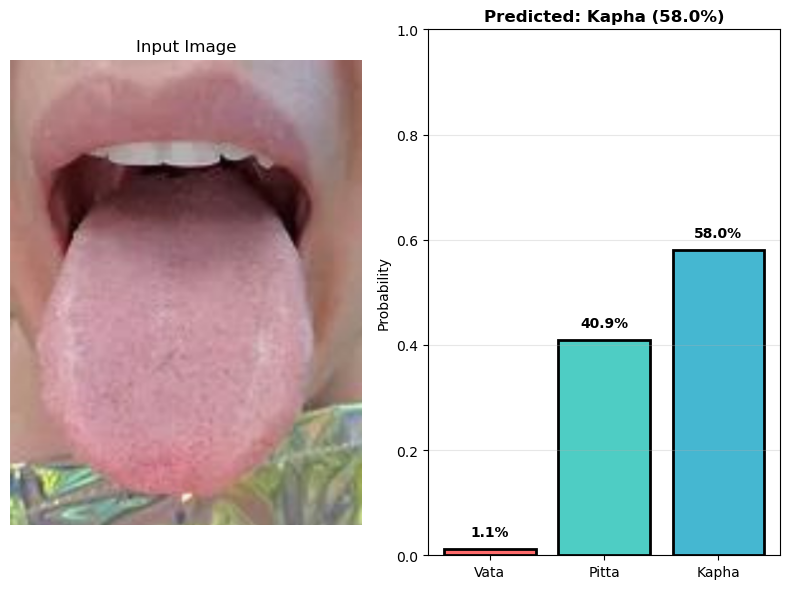

In [22]:
# Load trained model for inference
MODEL_PATH = CONFIG['model_save_path']
IMG_PATH = r"C:\5th SEM\ML Project\TongeImageDataset\sample\kapha.png"  # Change this to your test image
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model_inference = models.resnet50(pretrained=False)
model_inference.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model_inference.fc.in_features, 3)
)
model_inference.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model_inference = model_inference.to(DEVICE)
model_inference.eval()

# Preprocessing
test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and predict
image = Image.open(IMG_PATH).convert("RGB")
x = test_tfms(image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    outputs = model_inference(x)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidence, pred = torch.max(probabilities, 1)

label_map = {0: "Vata", 1: "Pitta", 2: "Kapha"}
pred_label = label_map[pred.item()]

# Display results
print("🔮 Prediction Results:")
print(f"   Predicted Prakriti: {pred_label}")
print(f"   Confidence: {confidence.item()*100:.2f}%")
print(f"\n📊 Class Probabilities:")
for i, prob in enumerate(probabilities[0]):
    print(f"   {label_map[i]}: {prob.item()*100:.2f}%")

# Visualize
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Input Image", fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
probs = [probabilities[0][i].item() for i in range(3)]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
bars = plt.bar(label_map.values(), probs, color=colors, edgecolor='black', linewidth=2)
plt.title(f'Predicted: {pred_label} ({confidence.item()*100:.1f}%)', fontsize=12, fontweight='bold')
plt.ylabel('Probability')
plt.ylim(0, 1)
for bar, prob in zip(bars, probs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{prob*100:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7️⃣ Personalized Diet Recommendation System


In [5]:
class PrakritiDietSystem:
    """
    Complete integrated system for Prakriti classification and diet recommendation.
    
    This class encapsulates:
    1. Model loading and inference
    2. Prakriti prediction with confidence scores
    3. Automatic diet plan generation
    4. Visualization of results
    """
    
    def __init__(self, model_path, device='cuda'):
        """Initialize the system with trained model."""
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.label_map = {0: "Vata", 1: "Pitta", 2: "Kapha"}
        
        # Load model
        self.model = models.resnet50(pretrained=False)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.model.fc.in_features, 3)
        )
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model = self.model.to(self.device)
        self.model.eval()
        
        # Preprocessing pipeline
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Diet templates
        self.base_diets = {
            "Vata": {
                "Breakfast": [("Warm oatmeal with ghee and banana", 400)],
                "Mid-Morning Snack": [("Soaked almonds and dates", 150)],
                "Lunch": [("Khichdi with ghee and cooked vegetables", 600)],
                "Evening Snack": [("Herbal tea with sesame laddoo", 150)],
                "Dinner": [("Rice with moong dal soup and steamed vegetables", 500)],
                "Notes": "Focus on warm, oily, and nourishing foods. Avoid cold, dry, and raw foods."
            },
            "Pitta": {
                "Breakfast": [("Rice porridge with coconut milk and dates", 400)],
                "Mid-Morning Snack": [("Cucumber slices and coconut water", 150)],
                "Lunch": [("Steamed rice, sautéed greens, and dal", 600)],
                "Evening Snack": [("Sweet fruits like melon or pear", 150)],
                "Dinner": [("Vegetable soup and boiled rice with ghee", 500)],
                "Notes": "Favor cooling and mildly sweet foods. Avoid spicy, sour, or oily foods."
            },
            "Kapha": {
                "Breakfast": [("Millet porridge with ginger and cinnamon", 350)],
                "Mid-Morning Snack": [("Green tea and roasted chickpeas", 150)],
                "Lunch": [("Barley khichdi with steamed veggies", 550)],
                "Evening Snack": [("Herbal tea and apple", 150)],
                "Dinner": [("Light moong soup with vegetables", 450)],
                "Notes": "Eat light, dry, and warm foods. Avoid sweets, fried foods, and dairy."
            }
        }
        
        print(f"✅ Prakriti-Diet System initialized successfully!")
        print(f"   Device: {self.device}")
        print(f"   Model loaded from: {model_path}")
    
    def predict(self, image_path):
        """
        Predict Prakriti type from tongue image.
        
        Args:
            image_path (str): Path to the tongue image
            
        Returns:
            dict: Prediction results with prakriti, confidence, and probabilities
        """
        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        x = self.transform(image).unsqueeze(0).to(self.device)
        
        # Predict
        with torch.no_grad():
            outputs = self.model(x)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, pred = torch.max(probabilities, 1)
        
        pred_label = self.label_map[pred.item()]
        
        result = {
            'prakriti': pred_label,
            'confidence': confidence.item(),
            'probabilities': {
                self.label_map[i]: probabilities[0][i].item() 
                for i in range(3)
            },
            'image': image
        }
        
        return result
    
    def generate_diet_plan(self, prakriti_type, total_calories=2000):
        """
        Generate 7-day personalized diet plan based on Prakriti.
        
        Args:
            prakriti_type (str): Predicted Prakriti type
            total_calories (int): Target daily calorie intake
            
        Returns:
            tuple: (diet_dataframe, dietary_notes)
        """
        plan = self.base_diets.get(prakriti_type)
        
        # Compute calorie adjustment
        total = sum([item[1] for meal in plan if meal != "Notes" for item in plan[meal]])
        factor = total_calories / total
        
        # Generate 7-day plan
        days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        weekly_data = []
        
        for day in days:
            for meal, items in plan.items():
                if meal != "Notes":
                    for food, cal in items:
                        weekly_data.append({
                            "Day": day,
                            "Meal": meal,
                            "Food": food,
                            "Calories": round(cal * factor)
                        })
        
        df = pd.DataFrame(weekly_data)
        return df, plan["Notes"]
    
    def predict_and_recommend(self, image_path, total_calories=2000, visualize=True):
        """
        Complete pipeline: Predict Prakriti and generate diet recommendation.
        
        Args:
            image_path (str): Path to tongue image
            total_calories (int): Target daily calorie intake
            visualize (bool): Whether to display visualization
            
        Returns:
            dict: Complete results with prediction and diet plan
        """
        # Step 1: Predict Prakriti
        prediction = self.predict(image_path)
        
        # Step 2: Generate diet plan
        diet_df, dietary_notes = self.generate_diet_plan(
            prediction['prakriti'], 
            total_calories
        )
        
        # Step 3: Compile results
        results = {
            'prediction': prediction,
            'diet_plan': diet_df,
            'dietary_notes': dietary_notes,
            'target_calories': total_calories
        }
        
        # Step 4: Display results
        print("="*80)
        print("🌿 PRAKRITI CLASSIFICATION & DIET RECOMMENDATION SYSTEM 🌿")
        print("="*80)
        print(f"\n📊 PREDICTION RESULTS:")
        print(f"   Prakriti Type: {prediction['prakriti']}")
        print(f"   Confidence: {prediction['confidence']*100:.2f}%")
        print(f"\n   Class Probabilities:")
        for prakriti, prob in prediction['probabilities'].items():
            print(f"      {prakriti}: {prob*100:.2f}%")
        
        print(f"\n🍽️  PERSONALIZED DIET PLAN:")
        print(f"   Target: {total_calories} kcal/day")
        print(f"\n   7-Day Meal Plan:")
        print(diet_df.to_string(index=False))
        
        print(f"\n💡 DIETARY GUIDELINES FOR {prediction['prakriti']}:")
        print(f"   {dietary_notes}")
        print("="*80)
        
        # Step 5: Visualize (if requested)
        if visualize:
            self._visualize_results(results)
        
        return results
    
    def _visualize_results(self, results):
        """Create comprehensive visualization of prediction and diet plan."""
        fig = plt.figure(figsize=(16, 6))
        
        # Subplot 1: Input Image
        ax1 = plt.subplot(1, 3, 1)
        ax1.imshow(results['prediction']['image'])
        ax1.set_title(f"Input Tongue Image", fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # Subplot 2: Prediction Probabilities
        ax2 = plt.subplot(1, 3, 2)
        probs = results['prediction']['probabilities']
        prakriti_names = list(probs.keys())
        prob_values = list(probs.values())
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
        
        bars = ax2.bar(prakriti_names, prob_values, color=colors, edgecolor='black', linewidth=2)
        ax2.set_title(f'Predicted: {results["prediction"]["prakriti"]} '
                     f'({results["prediction"]["confidence"]*100:.1f}%)', 
                     fontsize=12, fontweight='bold')
        ax2.set_ylabel('Probability', fontsize=11)
        ax2.set_ylim(0, 1)
        ax2.grid(axis='y', alpha=0.3)
        
        for bar, prob in zip(bars, prob_values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02, 
                    f'{prob*100:.1f}%', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
        
        # Subplot 3: Diet Plan Summary (Daily Calorie Distribution)
        ax3 = plt.subplot(1, 3, 3)
        diet_summary = results['diet_plan'].groupby('Meal')['Calories'].first()
        meal_order = ['Breakfast', 'Mid-Morning Snack', 'Lunch', 'Evening Snack', 'Dinner']
        diet_summary = diet_summary.reindex(meal_order)
        
        colors_meals = ['#ffd93d', '#6bcf7f', '#ff6b6b', '#95e1d3', '#a29bfe']
        wedges, texts, autotexts = ax3.pie(diet_summary.values, 
                                           labels=diet_summary.index,
                                           autopct='%1.0f%%',
                                           colors=colors_meals,
                                           startangle=90,
                                           textprops={'fontsize': 9, 'fontweight': 'bold'})
        ax3.set_title(f'Daily Calorie Distribution\n({results["target_calories"]} kcal)', 
                     fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return fig

# Initialize the integrated system
print("🔧 Initializing Prakriti-Diet Recommendation System...")
prakriti_system = PrakritiDietSystem(
    model_path=CONFIG['model_save_path'],
    device=CONFIG['device']
)
print("\n✅ System ready for predictions!")

🔧 Initializing Prakriti-Diet Recommendation System...


c:\Users\ankit\anaconda3\envs\torch_cuda12_8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ankit\anaconda3\envs\torch_cuda12_8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Prakriti-Diet System initialized successfully!
   Device: cuda
   Model loaded from: resnet50_tongue_augmented.pth

✅ System ready for predictions!


In [ ]:
import glob

# Find all test images
sample_images = glob.glob(r"C:\5th SEM\ML Project\TongeImageDataset\sample\*.png")[:3]

print("="*80)
print("🔄 BATCH PROCESSING DEMO: Processing Multiple Patients")
print("="*80)

batch_results = []

for i, img_path in enumerate(sample_images, 1):
    print(f"\n{'='*80}")
    print(f"Processing Patient {i}: {os.path.basename(img_path)}")
    print(f"{'='*80}")
    
    result = prakriti_system.predict_and_recommend(
        image_path=img_path,
        total_calories=2000,
        visualize=False  # Set to False for batch processing
    )
    
    batch_results.append({
        'patient_id': f"Patient_{i}",
        'image': os.path.basename(img_path),
        'prakriti': result['prediction']['prakriti'],
        'confidence': result['prediction']['confidence']
    })

# Summary of batch processing
print("\n" + "="*80)
print("📊 BATCH PROCESSING SUMMARY")
print("="*80)
batch_df = pd.DataFrame(batch_results)
print(batch_df.to_string(index=False))
print("="*80)

🔄 BATCH PROCESSING DEMO: Processing Multiple Patients

Processing Patient 1: kapha1.png
🌿 PRAKRITI CLASSIFICATION & DIET RECOMMENDATION SYSTEM 🌿

📊 PREDICTION RESULTS:
   Prakriti Type: Kapha
   Confidence: 57.98%

   Class Probabilities:
      Vata: 1.11%
      Pitta: 40.91%
      Kapha: 57.98%

🍽️  PERSONALIZED DIET PLAN:
   Target: 2000 kcal/day

   7-Day Meal Plan:
      Day              Meal                                     Food  Calories
   Monday         Breakfast Millet porridge with ginger and cinnamon       424
   Monday Mid-Morning Snack          Green tea and roasted chickpeas       182
   Monday             Lunch      Barley khichdi with steamed veggies       667
   Monday     Evening Snack                     Herbal tea and apple       182
   Monday            Dinner         Light moong soup with vegetables       545
  Tuesday         Breakfast Millet porridge with ginger and cinnamon       424
  Tuesday Mid-Morning Snack          Green tea and roasted chickpeas       